In [2]:
# # https://archive.ics.uci.edu/ml/datasets/online+retail

import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import TABLEAU_COLORS

sys.path.append('../../..')
from uncertain.utils.data import Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation import test_vanilla, test_uncertain

from uncertain.implicit.base import MF
from uncertain.implicit.DoubleMF import DoubleMF, AUR, Pointwise, Pairwise

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    data.train_user_based = [u[:2] for u in data.train_val]
    data.user_based = False
    print(f'Data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
    data.batch_size = int(1e3)
else:
    data = pd.read_excel('Online Retail.xlsx', header=0)
    data = data[['CustomerID', 'StockCode', 'InvoiceDate']].rename(columns={'CustomerID': 'user', 'StockCode': 'item', 'InvoiceDate': 'timestamps'})
    data = data.dropna().drop_duplicates(subset=['user', 'item'])

    data = Data(data, min_user_len=10, min_item_len=5, implicit=True)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=5)

data.item_support = data.item_support.astype(float)
data.user_support = data.user_support.astype(float)        

base_batch_size = 1024
trials = 10 ## 0 for eval only mode
patience = 2 ## Number of validation checks before ending training

Data prepared: 3709 users, 3156 items.
171126 train, 40885 validation and 51173 test interactions.


# Base MF models

In [3]:
name = 'MF-BCEnew'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='BCE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
7,7,0.089141,2023-01-14 06:19:11.941488,2023-01-14 06:56:14.798796,0 days 00:37:02.857308,63,0.000162,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.974474,COMPLETE
6,6,0.087341,2023-01-14 05:19:59.843788,2023-01-14 06:19:11.940673,0 days 00:59:12.096885,74,0.000099,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.978511,COMPLETE
9,9,0.087086,2023-01-14 07:18:03.747130,2023-01-14 07:58:09.445148,0 days 00:40:05.698018,62,0.000077,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.978567,COMPLETE
8,8,0.086254,2023-01-14 06:56:14.799469,2023-01-14 07:18:03.746428,0 days 00:21:48.946959,16,0.000460,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.934243,COMPLETE
5,5,0.086168,2023-01-14 05:04:29.223292,2023-01-14 05:19:59.843147,0 days 00:15:30.619855,12,0.000815,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.909781,COMPLETE
3,3,0.085716,2023-01-14 03:36:36.530550,2023-01-14 04:13:58.908384,0 days 00:37:22.377834,51,0.000073,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.972107,COMPLETE
2,2,0.083836,2023-01-14 02:59:59.302707,2023-01-14 03:36:36.529932,0 days 00:36:37.227225,42,0.000027,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.969264,COMPLETE
1,1,0.083571,2023-01-14 02:12:02.209496,2023-01-14 02:59:59.302117,0 days 00:47:57.092621,51,0.000014,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.976563,COMPLETE
0,0,0.081424,2023-01-14 01:43:57.315761,2023-01-14 02:12:02.208807,0 days 00:28:04.893046,58,0.000529,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.969776,COMPLETE
4,4,0.080751,2023-01-14 04:13:58.909042,2023-01-14 05:04:29.222675,0 days 00:50:30.313633,70,0.000557,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.974327,COMPLETE


In [9]:
name = 'MF-Flat'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Flat', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
0,0,0.030569,2023-01-26 22:54:12.294326,2023-01-26 22:57:37.072696,0 days 00:03:24.778370,14,0.000010,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.933588,COMPLETE
8,8,0.030060,2023-01-27 00:40:40.784743,2023-01-27 00:53:09.306332,0 days 00:12:28.521589,37,0.000183,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.973088,COMPLETE
7,7,0.029597,2023-01-27 00:33:48.470893,2023-01-27 00:40:40.784000,0 days 00:06:52.313107,27,0.000052,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.964117,COMPLETE
9,9,0.028551,2023-01-27 00:53:09.307120,2023-01-27 01:04:46.990257,0 days 00:11:37.683137,35,0.000804,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.970219,COMPLETE
5,5,0.027018,2023-01-27 00:10:02.504603,2023-01-27 00:19:44.356809,0 days 00:09:41.852206,39,0.000728,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.972786,COMPLETE
4,4,0.026084,2023-01-26 23:47:55.959962,2023-01-27 00:10:02.503540,0 days 00:22:06.543578,45,0.000217,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.977668,COMPLETE
2,2,0.025674,2023-01-26 23:11:15.331752,2023-01-26 23:22:27.933495,0 days 00:11:12.601743,49,0.000018,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.979950,COMPLETE
1,1,0.025595,2023-01-26 22:57:37.073391,2023-01-26 23:11:15.331062,0 days 00:13:38.257671,43,0.000149,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.976861,COMPLETE
6,6,0.023236,2023-01-27 00:19:44.357549,2023-01-27 00:33:48.470128,0 days 00:14:04.112579,56,0.000581,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.980624,COMPLETE
3,3,0.019295,2023-01-26 23:22:27.934223,2023-01-26 23:47:55.959246,0 days 00:25:28.025023,71,0.000141,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.985874,COMPLETE


In [5]:
name = 'MF-BPRnew'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='BPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_wd,user_attrs_filename,user_attrs_mean_loss,state
5,5,0.071535,2023-01-14 08:41:09.326113,2023-01-14 08:51:10.508976,0 days 00:10:01.182863,0.000857,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.902749,COMPLETE
9,9,0.070839,2023-01-14 09:14:45.021402,2023-01-14 09:23:56.133169,0 days 00:09:11.111767,0.000666,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.890090,COMPLETE
0,0,0.068650,2023-01-14 07:58:12.986050,2023-01-14 08:08:07.440171,0 days 00:09:54.454121,0.000343,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.917568,COMPLETE
4,4,0.068122,2023-01-14 08:31:48.712646,2023-01-14 08:41:09.325496,0 days 00:09:20.612850,0.000097,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.910733,COMPLETE
2,2,0.067535,2023-01-14 08:16:27.807004,2023-01-14 08:24:37.404857,0 days 00:08:09.597853,0.000068,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.897574,COMPLETE
6,6,0.065737,2023-01-14 08:51:10.509690,2023-01-14 09:00:16.066234,0 days 00:09:05.556544,0.000010,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.910830,COMPLETE
1,1,0.064444,2023-01-14 08:08:07.440814,2023-01-14 08:16:27.806411,0 days 00:08:20.365597,0.000027,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.900711,COMPLETE
7,7,0.061720,2023-01-14 09:00:16.066854,2023-01-14 09:07:59.011204,0 days 00:07:42.944350,0.000047,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898537,COMPLETE
3,3,0.061646,2023-01-14 08:24:37.405477,2023-01-14 08:31:48.712048,0 days 00:07:11.306571,0.000022,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.881827,COMPLETE
8,8,0.058785,2023-01-14 09:07:59.011816,2023-01-14 09:14:45.020817,0 days 00:06:46.009001,0.000021,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.870124,COMPLETE


In [6]:
name = 'MF-MSE'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='MSE', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfmse = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfmse, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
9,9,0.099246,2023-01-14 10:13:24.859768,2023-01-14 10:36:13.895720,0 days 00:22:49.035952,34,0.000128,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.991680,COMPLETE
3,3,0.097393,2023-01-13 18:47:57.213510,2023-01-13 19:10:10.737305,0 days 00:22:13.523795,43,0.000195,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.992746,COMPLETE
4,4,0.097114,2023-01-13 20:58:14.341594,2023-01-13 21:33:04.794120,0 days 00:34:50.452526,61,0.000067,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.994607,COMPLETE
8,8,0.096395,2023-01-14 09:50:26.395995,2023-01-14 10:13:24.859143,0 days 00:22:58.463148,39,0.000071,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.992299,COMPLETE
5,5,0.096284,2023-01-13 21:33:04.794863,2023-01-13 22:09:40.819717,0 days 00:36:36.024854,74,0.000145,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.995361,COMPLETE
7,7,0.094740,2023-01-14 09:35:10.000463,2023-01-14 09:50:26.395428,0 days 00:15:16.394965,22,0.000248,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.988061,COMPLETE
6,6,0.092945,2023-01-14 09:23:58.738245,2023-01-14 09:35:09.999902,0 days 00:11:11.261657,10,0.000717,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.981085,COMPLETE
2,2,0.091242,2023-01-13 18:37:02.753066,2023-01-13 18:47:57.212702,0 days 00:10:54.459636,31,0.000030,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.990435,COMPLETE
1,1,0.075063,2023-01-13 16:30:47.295173,2023-01-13 16:41:21.128108,0 days 00:10:33.832935,33,0.002273,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.989647,COMPLETE
0,0,0.048102,2023-01-13 16:24:13.776772,2023-01-13 16:30:47.294480,0 days 00:06:33.517708,26,0.004693,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.986419,COMPLETE


In [7]:
name = 'MF-Pointwise'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Pointwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfpoint = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfpoint, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
6,6,0.090222,2023-01-14 10:36:17.746645,2023-01-14 11:12:04.461147,0 days 00:35:46.714502,34,0.000493,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.964212,COMPLETE
9,9,0.087830,2023-01-14 13:14:24.413125,2023-01-14 14:10:51.607677,0 days 00:56:27.194552,28,0.000429,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.964926,COMPLETE
8,8,0.085485,2023-01-14 11:49:55.208513,2023-01-14 13:14:24.410521,0 days 01:24:29.202008,76,0.000084,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.980991,COMPLETE
0,0,0.085471,2023-01-13 16:41:24.895996,2023-01-13 17:17:01.029967,0 days 00:35:36.133971,34,0.000296,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.969708,COMPLETE
1,1,0.084020,2023-01-13 17:17:01.030647,2023-01-13 17:55:26.954631,0 days 00:38:25.923984,37,0.000153,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.970635,COMPLETE
5,5,0.083157,2023-01-13 23:06:46.242590,2023-01-14 00:27:48.941998,0 days 01:21:02.699408,74,0.000015,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.985194,COMPLETE
2,2,0.082690,2023-01-13 19:10:14.201956,2023-01-13 19:43:09.207896,0 days 00:32:55.005940,34,0.000110,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.966543,COMPLETE
7,7,0.082227,2023-01-14 11:12:04.461706,2023-01-14 11:49:55.207298,0 days 00:37:50.745592,55,0.000167,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.973033,COMPLETE
4,4,0.080756,2023-01-13 22:09:43.356421,2023-01-13 23:06:46.242026,0 days 00:57:02.885605,64,0.000010,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.980797,COMPLETE
3,3,0.078715,2023-01-13 19:43:09.208494,2023-01-13 20:04:51.154069,0 days 00:21:41.945575,28,0.000100,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.964818,COMPLETE


In [8]:
name = 'MF-Pairwise'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, embedding_dim=128, loss='Pairwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
mfpair = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfpair, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_wd,user_attrs_filename,user_attrs_mean_loss,state
7,7,0.067793,2023-01-14 14:25:00.659710,2023-01-14 14:37:11.389917,0 days 00:12:10.730207,0.000773,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.885660,COMPLETE
6,6,0.067654,2023-01-14 14:10:56.192085,2023-01-14 14:25:00.658957,0 days 00:14:04.466872,0.000230,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.914369,COMPLETE
5,5,0.065822,2023-01-14 00:56:26.740737,2023-01-14 01:09:45.009466,0 days 00:13:18.268729,0.000234,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.907782,COMPLETE
8,8,0.063818,2023-01-14 14:37:11.390870,2023-01-14 14:52:11.597025,0 days 00:15:00.206155,0.000041,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.907207,COMPLETE
9,9,0.063417,2023-01-14 14:52:11.597746,2023-01-14 15:04:27.302847,0 days 00:12:15.705101,0.000563,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.900221,COMPLETE
3,3,0.062632,2023-01-14 00:27:54.505404,2023-01-14 00:42:27.589284,0 days 00:14:33.083880,0.000018,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.907323,COMPLETE
1,1,0.061392,2023-01-13 18:05:39.200000,2023-01-13 18:17:04.425672,0 days 00:11:25.225672,0.000265,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893849,COMPLETE
4,4,0.060606,2023-01-14 00:42:27.590299,2023-01-14 00:56:26.739748,0 days 00:13:59.149449,0.000029,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.899774,COMPLETE
2,2,0.060558,2023-01-13 20:04:53.568265,2023-01-13 20:11:43.459540,0 days 00:06:49.891275,0.000023,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.899305,COMPLETE
0,0,0.051314,2023-01-13 17:55:31.516754,2023-01-13 18:01:57.220418,0 days 00:06:25.703664,0.001672,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.806734,COMPLETE


# Uncertainty MF models

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,user_attrs_filename,user_attrs_mean_loss,state
6,6,0.100954,2023-01-14 19:20:00.381166,2023-01-14 19:52:36.752267,0 days 00:32:36.371101,0.000074,37,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,41.172779,COMPLETE
2,2,0.100241,2023-01-14 16:44:34.132587,2023-01-14 18:08:20.172892,0 days 01:23:46.040305,0.000053,81,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,48.875999,COMPLETE
4,4,0.100023,2023-01-14 18:28:35.379663,2023-01-14 19:02:20.370390,0 days 00:33:44.990727,0.000051,82,0.3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,37.791054,COMPLETE
0,0,0.099624,2023-01-14 15:04:32.615560,2023-01-14 15:48:03.568856,0 days 00:43:30.953296,0.000204,95,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,31.508522,COMPLETE
5,5,0.099620,2023-01-14 19:02:20.371128,2023-01-14 19:20:00.379133,0 days 00:17:40.008005,0.000273,20,0.2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,37.363949,COMPLETE
8,8,0.098267,2023-01-14 21:37:56.983846,2023-01-14 21:53:53.603933,0 days 00:15:56.620087,0.001321,38,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,30.229002,COMPLETE
1,1,0.094715,2023-01-14 15:48:03.570203,2023-01-14 16:44:34.131910,0 days 00:56:30.561707,0.002621,65,0.7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,34.109360,COMPLETE
9,9,0.093078,2023-01-14 21:53:53.604618,2023-01-14 22:42:17.954782,0 days 00:48:24.350164,0.000609,61,0.7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,39.886951,COMPLETE
7,7,0.091874,2023-01-14 19:52:36.753041,2023-01-14 21:37:56.983059,0 days 01:45:20.230018,0.000032,90,0.8,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,58.157131,COMPLETE
3,3,0.089528,2023-01-14 18:08:20.174213,2023-01-14 18:28:35.378919,0 days 00:20:15.204706,0.003571,28,0.7,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,23.394882,COMPLETE


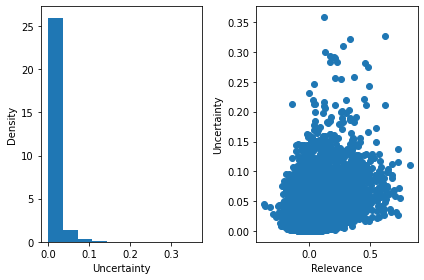

In [3]:
name = 'AUR'
def init_model(**kwargs):
    return AUR(baseline=mfmse, embedding_dim=128, beta=1/2, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.8, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.090593,2023-01-17 13:33:33.093673,2023-01-17 13:45:38.639744,0 days 00:12:05.546071,0.000025,36,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.968607,COMPLETE
0,0,0.089703,2023-01-17 13:25:16.583609,2023-01-17 13:33:33.092830,0 days 00:08:16.509221,0.002215,33,0.4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.975287,COMPLETE


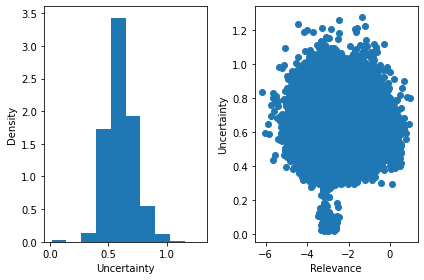

In [3]:
name = 'Pointwise-AURratio'
def init_model(**kwargs):
    return Pointwise(baseline=mfpoint, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.4, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=2)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,user_attrs_filename,user_attrs_mean_loss,state
0,0,0.090775,2023-01-15 01:09:38.570971,2023-01-15 01:15:34.765271,0 days 00:05:56.194300,0.000096,21,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.959894,COMPLETE
4,4,0.089756,2023-01-15 01:59:23.063881,2023-01-15 02:20:15.369292,0 days 00:20:52.305411,0.000022,90,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.987010,COMPLETE
8,8,0.089417,2023-01-15 02:52:08.692978,2023-01-15 02:59:12.616939,0 days 00:07:03.923961,0.000320,30,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.966372,COMPLETE
2,2,0.089387,2023-01-15 01:29:37.586132,2023-01-15 01:46:48.538601,0 days 00:17:10.952469,0.000062,77,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.983896,COMPLETE
6,6,0.089239,2023-01-15 02:34:41.830539,2023-01-15 02:44:19.631420,0 days 00:09:37.800881,0.000070,30,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.965378,COMPLETE
5,5,0.089151,2023-01-15 02:20:15.369988,2023-01-15 02:34:41.829915,0 days 00:14:26.459927,0.000070,63,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.984171,COMPLETE
7,7,0.089108,2023-01-15 02:44:19.631988,2023-01-15 02:52:08.692351,0 days 00:07:49.060363,0.007248,48,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,1.003462,COMPLETE
9,9,0.089049,2023-01-15 02:59:12.617545,2023-01-15 03:19:44.512136,0 days 00:20:31.894591,0.000054,89,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.985813,COMPLETE
1,1,0.088350,2023-01-15 01:15:34.765899,2023-01-15 01:29:37.585589,0 days 00:14:02.819690,0.000517,94,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.990678,COMPLETE
3,3,0.088312,2023-01-15 01:46:48.539568,2023-01-15 01:59:23.063197,0 days 00:12:34.523629,0.000854,82,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.990814,COMPLETE


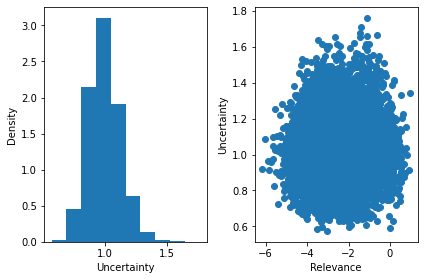

In [3]:
name = 'Pointwise'
def init_model(**kwargs):
    return Pointwise(baseline=mfpoint, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'n_negatives': trial.suggest_int('neg', 20, 100),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,user_attrs_filename,user_attrs_mean_loss,state
1,1,0.068732,2023-01-15 03:21:10.123230,2023-01-15 03:21:59.679932,0 days 00:00:49.556702,0.000109,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.895412,COMPLETE
2,2,0.067683,2023-01-15 03:21:59.680475,2023-01-15 03:22:45.175794,0 days 00:00:45.495319,0.000105,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.891192,COMPLETE
8,8,0.067564,2023-01-15 03:28:19.163444,2023-01-15 03:29:08.415579,0 days 00:00:49.252135,0.000797,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.896435,COMPLETE
0,0,0.066280,2023-01-15 03:20:05.558341,2023-01-15 03:21:10.122564,0 days 00:01:04.564223,0.000023,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.895100,COMPLETE
4,4,0.066186,2023-01-15 03:23:53.091179,2023-01-15 03:25:14.301691,0 days 00:01:21.210512,0.003296,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898293,COMPLETE
9,9,0.065767,2023-01-15 03:29:08.416199,2023-01-15 03:30:15.740439,0 days 00:01:07.324240,0.005463,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.898822,COMPLETE
6,6,0.065426,2023-01-15 03:26:41.558256,2023-01-15 03:27:30.734247,0 days 00:00:49.175991,0.000162,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.899582,COMPLETE
5,5,0.064834,2023-01-15 03:25:14.302491,2023-01-15 03:26:41.557623,0 days 00:01:27.255132,0.000059,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893697,COMPLETE
7,7,0.064244,2023-01-15 03:27:30.734916,2023-01-15 03:28:19.162818,0 days 00:00:48.427902,0.004621,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.901298,COMPLETE
3,3,0.063537,2023-01-15 03:22:45.176508,2023-01-15 03:23:53.090577,0 days 00:01:07.914069,0.001173,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.893428,COMPLETE


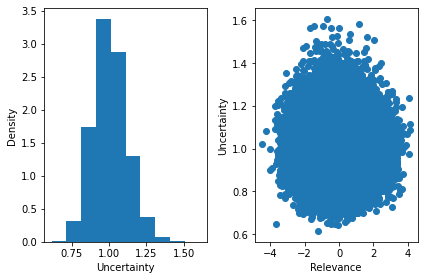

In [12]:
name = 'Pairwise'
def init_model(**kwargs):
    return Pairwise(baseline=mfpair, embedding_dim=128, **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

# Joint MF models

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_ratio,params_wd,user_attrs_filename,user_attrs_mean_loss,state
2,2,0.061538,2023-01-20 11:29:23.039764,2023-01-20 11:36:23.117114,0 days 00:07:00.077350,0.003801,33,0.4,0.000036,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,19.087610,COMPLETE
3,3,0.060938,2023-01-20 11:36:23.117686,2023-01-20 11:40:53.511105,0 days 00:04:30.393419,0.000046,20,0.4,0.000761,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,24.541946,COMPLETE
0,0,0.058246,2023-01-15 23:56:44.407144,2023-01-16 00:04:23.352425,0 days 00:07:38.945281,0.000054,34,0.5,0.000150,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,36.042103,COMPLETE
4,4,0.032116,2023-01-20 11:40:53.511756,2023-01-20 12:04:58.911380,0 days 00:24:05.399624,0.004994,67,0.8,0.000029,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,45.669243,COMPLETE
1,1,0.021740,2023-01-20 11:09:12.599070,2023-01-20 11:29:23.039113,0 days 00:20:10.440043,0.000047,74,0.7,0.000068,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,221.276093,COMPLETE


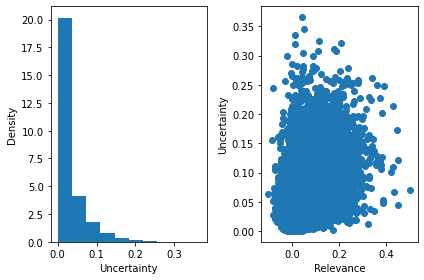

In [2]:
name = 'AUR-J'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, embedding_dim=128, embedding_dim_var=128, beta=1/2, loss='AUR', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80),
              'gamma': trial.suggest_float('gamma', 1e-5, 1e-2, log=True),
              'ratio': trial.suggest_float('ratio', 0.2, 0.8, step=0.1)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=4)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_neg,params_wd,user_attrs_filename,user_attrs_mean_loss,state
2,2,0.030037,2023-01-16 00:27:52.145557,2023-01-16 00:32:52.870451,0 days 00:05:00.724894,0.001205,32,0.000050,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.95419,COMPLETE
3,3,0.010135,2023-01-16 00:53:31.699189,2023-01-16 00:57:49.255028,0 days 00:04:17.555839,0.206793,63,0.000013,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,-inf,COMPLETE
0,0,0.010135,2023-01-16 00:11:44.920767,2023-01-16 00:16:08.231283,0 days 00:04:23.310516,0.004059,62,0.000011,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,-inf,COMPLETE
1,1,-inf,2023-01-16 00:24:12.443221,2023-01-16 00:27:36.367497,0 days 00:03:23.924276,0.000589,71,0.000908,,-inf,COMPLETE


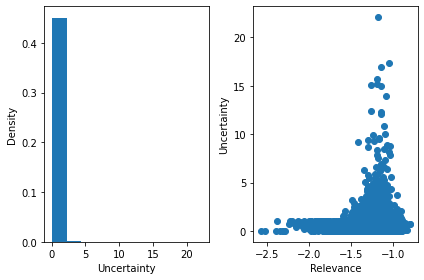

In [11]:
name = 'Pointwise-J'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, embedding_dim=128, embedding_dim_var=128, loss='Pointwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'n_negatives': trial.suggest_int('neg', 10, 80),
              'gamma': trial.suggest_float('gamma', 1e-2, 1, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / (params['n_negatives'] + 1))
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=1)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

,number,value,datetime_start,datetime_complete,duration,params_gamma,params_wd,user_attrs_filename,user_attrs_mean_loss,state
0,0,0.016969,2023-01-16 00:41:47.053704,2023-01-16 00:42:31.260580,0 days 00:00:44.206876,0.000133,0.000104,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,0.668246,COMPLETE
2,2,0.015204,2023-01-16 00:48:31.708379,2023-01-16 00:49:26.621402,0 days 00:00:54.913023,0.323845,0.000887,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,206.915070,COMPLETE
1,1,0.010288,2023-01-16 00:45:45.452261,2023-01-16 00:46:27.517505,0 days 00:00:42.065244,0.049745,0.000231,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,21.500820,COMPLETE


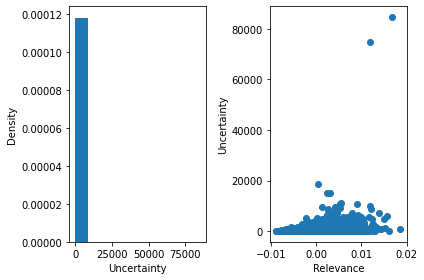

In [10]:
name = 'Pairwise-J'
def init_model(**kwargs):
    return DoubleMF(data.n_user, data.n_item, embedding_dim=128, embedding_dim_var=128, loss='Pairwise', **kwargs)

def objective(trial):
    
    # Parameter setup
    params = {'weight_decay': trial.suggest_float('wd', 1e-5, 1e-3, log=True),
              'gamma': trial.suggest_float('gamma', 1e-2, 1, log=True)}
    params_str = '-'.join(f'{key}={value}' for key, value in params.items())
    data.batch_size = int(base_batch_size / 2)
    print(params, data.batch_size)

    # Train
    model = init_model(**params)
    recall, path, train_likelihood = train(model, data, path='checkpoints/' + name, name=params_str, patience=patience)
    trial.set_user_attr('filename', path)
    trial.set_user_attr('mean_loss', train_likelihood)
    return recall

study = run_study(name, objective, n_trials=1)
best_runs = study.trials_dataframe().sort_values('value')[::-1]
model = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(model, data, max_k=10, name=name)

clear_output(wait=True)
best_runs

# Joint MLP models

In [ ]:
# Go on from here

# Results

In [4]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['MF-BCEnew', 'MF-BPRnew', 'MF-MSE', 'MF-Pointwise', 'MF-Pairwise', 
         'AUR', 'Pointwise', 'Pairwise', 'AUR-1024', 'Pointwise-AURratio']
drop = ['MF-BCEnew', 'MF-BPRnew', 'MF-MSE', 'MF-Pointwise', 'MF-Pairwise']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r', 'm']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
results[['FCP', 'URI', 'UAC']].T

,MF-BCEnew,MF-BPRnew,MF-MSE,MF-Pointwise,MF-Pairwise,AUR,Pointwise,Pairwise,AUR-1024,Pointwise-AURratio
FCP,0.685811,0.690814,0.633498,0.653802,0.688312,0.633498,0.653802,0.688312,0.633498,0.653802
URI,NaN,NaN,NaN,NaN,NaN,-0.149441,-0.020936,-0.038404,-0.095516,-0.046340
UAC,NaN,NaN,NaN,NaN,NaN,0.052336,0.018016,0.010995,0.009291,0.028345


In [5]:
results['Average_Surprise']

MF-BCEnew             [0.22234277285331394, 0.22713215445413934, 0.2...
MF-BPRnew             [0.22179054106854465, 0.22606680134151297, 0.2...
MF-MSE                [0.20838656011915194, 0.21321987367203865, 0.2...
MF-Pointwise          [0.22086701007944048, 0.22588570353490886, 0.2...
MF-Pairwise           [0.20923053567121197, 0.21033547403278705, 0.2...
AUR                   [0.20838656011915194, 0.21321987367203865, 0.2...
Pointwise             [0.22086701007944048, 0.22588570353490886, 0.2...
Pairwise              [0.20923053567121197, 0.21033547403278705, 0.2...
AUR-1024              [0.20838656011915194, 0.21321987367203865, 0.2...
Pointwise-AURratio    [0.22086701007944048, 0.22588570353490886, 0.2...
Name: Average_Surprise, dtype: object

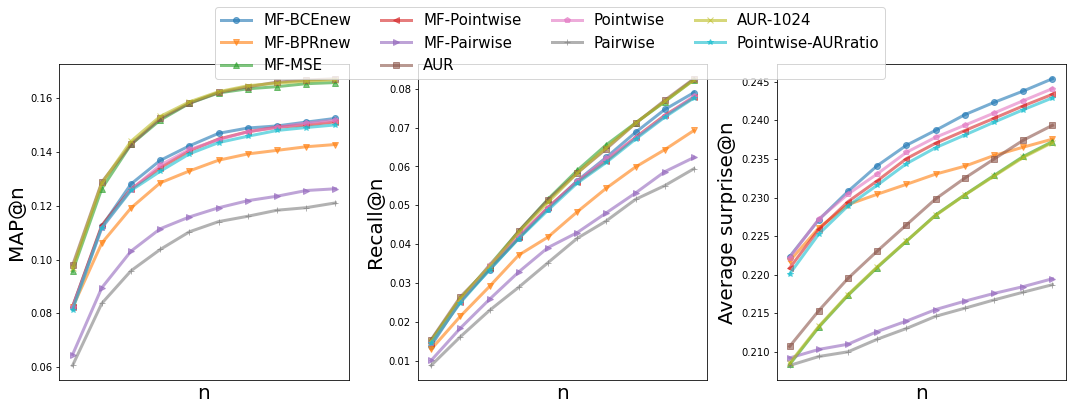

In [6]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(15, 5), ncols=3, sharex=True)
for index, row in results.iterrows():
    try:
        ax[0].plot(np.arange(1, 11), row['MAP2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[1].plot(np.arange(1, 11), row['Recall2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[2].plot(np.arange(1, 11), row['Average_Surprise2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    except:
        ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[2].plot(np.arange(1, 11), row['Average_Surprise'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11, 11) - 1)
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
ax[2].set_xlabel('n', fontsize=20)
ax[2].set_ylabel('Average surprise@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=4, bbox_to_anchor=(0.83, 1.15))
f.tight_layout()
f.savefig('plots/accuracy.pdf', bbox_inches='tight')

In [7]:
## Difference between vanilla predictions and uncertainty predictions (for those that perform it)
metrics = ['MAP', 'MAP2', 'Recall', 'Recall2', 'Average_Surprise', 'Average_Surprise2']
results.drop(index=drop)[metrics].transform(lambda x: x.str[-1])

,MAP,MAP2,Recall,Recall2,Average_Surprise,Average_Surprise2
AUR,0.165722,0.167136,0.082348,0.082552,0.237243,0.239348
Pointwise,0.151125,0.151696,0.077785,0.078103,0.243356,0.244101
Pairwise,0.126269,0.121023,0.062315,0.059430,0.219484,0.218717
AUR-1024,0.165722,0.166765,0.082348,0.082202,0.237243,0.237117
Pointwise-AURratio,0.151125,0.149992,0.077785,0.077613,0.243356,0.242898


# MF

[0.08168256 0.1091954  0.12209587 0.13073695 0.13658255 0.13907231
 0.14183669 0.14376934 0.14479044 0.14509524]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
3,3,0.131774,2022-12-14 16:15:50.742334,2022-12-14 16:25:21.434605,0 days 00:09:30.692271,256,128,0.000216,20,0.000090,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.130198,2022-12-14 16:41:34.351950,2022-12-14 16:47:54.606615,0 days 00:06:20.254665,256,128,0.000275,17,0.000043,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
9,9,0.129950,2022-12-14 16:51:36.884836,2022-12-14 16:57:16.612580,0 days 00:05:39.727744,256,128,0.000932,6,0.000061,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
17,17,0.128578,2022-12-14 17:30:58.364002,2022-12-14 17:39:01.664387,0 days 00:08:03.300385,256,128,0.000331,19,0.000048,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
16,16,0.128517,2022-12-14 17:26:19.849432,2022-12-14 17:30:58.363313,0 days 00:04:38.513881,256,128,0.000621,15,0.000023,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


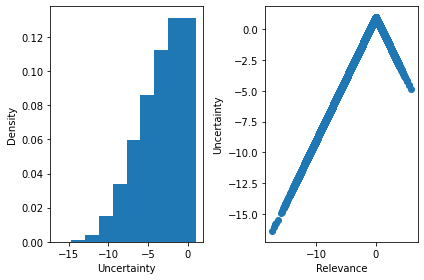

In [3]:
name = 'MF-BCE'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, loss='BCE', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mfbce = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfbce, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.07776962 0.1056493  0.11956877 0.12700741 0.13304496 0.13654317
 0.1392273  0.14064091 0.14196877 0.14241321]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
9,9,0.133425,2022-12-14 14:39:11.493908,2022-12-14 14:49:56.965021,0 days 00:10:45.471113,256,128,0.000260,4.429161e-05,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
15,15,0.131452,2022-12-14 15:28:06.310810,2022-12-14 15:37:22.061590,0 days 00:09:15.750780,256,128,0.000368,1.698307e-05,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
19,19,0.131059,2022-12-14 15:58:17.025174,2022-12-14 16:02:37.003971,0 days 00:04:19.978797,256,128,0.000456,2.956130e-05,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
10,10,0.130631,2022-12-14 14:49:56.966157,2022-12-14 15:02:41.730379,0 days 00:12:44.764222,256,128,0.000320,4.302754e-06,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
11,11,0.128920,2022-12-14 15:02:41.731424,2022-12-14 15:10:18.734095,0 days 00:07:37.002671,256,128,0.000312,6.036779e-07,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


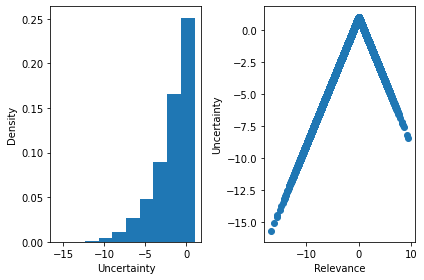

In [2]:
name = 'MF-BPR'
def init_model(**kwargs):
    return MF(data.n_user, data.n_item, loss='BPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mfbpr = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_vanilla(mfbpr, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

# CPMF trial

[0.07263389 0.09880167 0.1108258  0.11816256 0.1230775  0.12829475
 0.13053833 0.1328668  0.1345253  0.13538468]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_var,params_wd,user_attrs_filename,state
11,11,0.127602,2022-12-14 19:17:46.029905,2022-12-14 19:29:50.650946,0 days 00:12:04.621041,256,128,0.000416,20,17.071496,0.000005,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
19,19,0.125952,2022-12-14 20:22:32.336131,2022-12-14 20:34:09.495373,0 days 00:11:37.159242,256,128,0.000575,14,20.539861,0.000029,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
4,4,0.124571,2022-12-14 18:33:12.944030,2022-12-14 18:41:14.105725,0 days 00:08:01.161695,256,128,0.000236,6,2.906212,0.000030,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.123309,2022-12-14 18:57:16.339063,2022-12-14 19:03:41.603479,0 days 00:06:25.264416,256,128,0.000531,19,12.954882,0.000007,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
15,15,0.122608,2022-12-14 19:51:58.232620,2022-12-14 19:59:12.871372,0 days 00:07:14.638752,256,128,0.000705,3,21.844385,0.000015,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


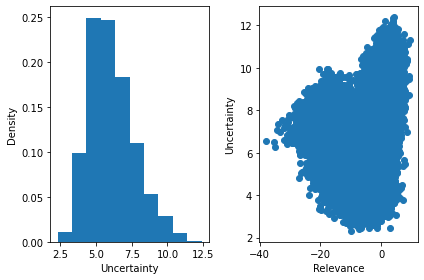

In [2]:
name = 'CPMF-Pointwise'
def init_model(**kwargs):
    return CPMF(data.n_user, data.n_item, loss='GBR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'init_var': trial.suggest_float('var', 1, 25)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

[0.0672536  0.09219858 0.10672945 0.11585283 0.12116654 0.12521161
 0.1281438  0.12986192 0.13169374 0.13273987]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_var,params_wd,user_attrs_filename,state
11,11,0.127598,2022-12-14 21:34:12.258588,2022-12-14 21:39:17.239681,0 days 00:05:04.981093,256,128,0.000671,1.350602,0.000080,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
14,14,0.127441,2022-12-14 21:49:22.057770,2022-12-14 21:54:40.498024,0 days 00:05:18.440254,256,128,0.000412,6.802396,0.000099,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
15,15,0.126807,2022-12-14 21:54:40.498621,2022-12-14 22:01:42.762906,0 days 00:07:02.264285,256,128,0.000367,6.276046,0.000097,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
16,16,0.124784,2022-12-14 22:01:42.763543,2022-12-14 22:07:01.601628,0 days 00:05:18.838085,256,128,0.000383,3.465397,0.000087,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
2,2,0.124143,2022-12-14 20:48:21.945527,2022-12-14 20:56:49.369424,0 days 00:08:27.423897,256,128,0.000543,11.725043,0.000054,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


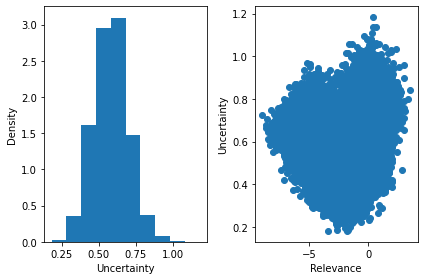

In [3]:
# NEED TO RERUN
name = 'CPMF-Pairwise'
def init_model(**kwargs):
    return CPMF(data.n_user, data.n_item, loss='GPR', **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4),
              'init_var': trial.suggest_float('var', 1, 25)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model().load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

# GER

[0.02861335 0.04255319 0.04911551 0.05359909 0.05689112 0.05954118
 0.06173716 0.06313105 0.06402796 0.06487909]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,user_attrs_filename,state
10,10,0.061214,2022-12-15 11:17:52.465606,2022-12-15 11:26:15.448882,0 days 00:08:22.983276,256,128,0.000314,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.060947,2022-12-15 11:01:43.426073,2022-12-15 11:03:37.982142,0 days 00:01:54.556069,256,128,0.003477,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
8,8,0.060724,2022-12-15 11:13:14.350857,2022-12-15 11:15:11.983849,0 days 00:01:57.632992,256,128,0.003634,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
6,6,0.060663,2022-12-15 11:06:44.446137,2022-12-15 11:10:52.610070,0 days 00:04:08.163933,256,128,0.000864,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
0,0,0.060523,2022-12-15 10:54:42.276350,2022-12-15 10:56:32.272226,0 days 00:01:49.995876,256,128,0.005477,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


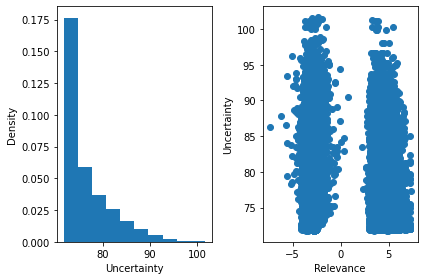

In [2]:
name = 'GER'
def init_model(**kwargs):
    return GER(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test_uncertain(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

# From here onwards I am keeping some old code

## User support

MF-NUS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.14386888 0.15734766 0.10886391 0.08490188 0.05506105 0.06084979
 0.04616756 0.03981959 0.04135802 0.03624661]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


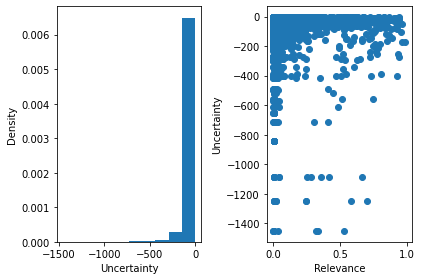

In [3]:
results = test_uncertain(UserSupport(base_MF=mf, uncertainty=-data.user_support), data, name='MF-NUS', max_k=10)
print(results['MAP-Uncertainty'])

## Item support

MF-NIS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.07025491 0.07068873 0.08071896 0.10578619 0.05331299 0.08798942
 0.09334309 0.10991064 0.11219246 0.11279401]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


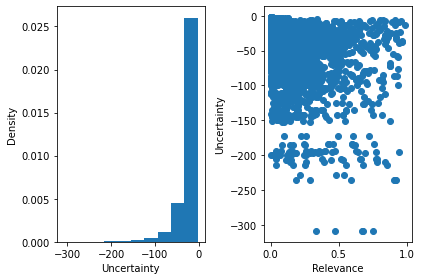

In [4]:
results = test_uncertain(ItemSupport(base_MF=mf, uncertainty=-data.item_support), data, name='MF-NIS', max_k=10)
print(results['MAP-Uncertainty'])

## Ensemble

MF-ENSEMBLE - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.04437643 0.06694721 0.07529967 0.08008162 0.08278288 0.08521848
 0.08698188 0.08777887 0.0882915  0.08893152]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


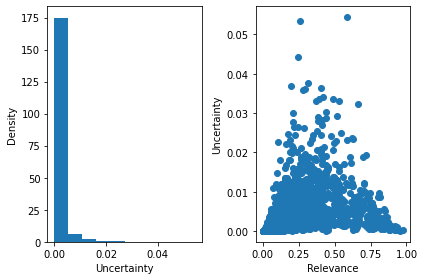

In [5]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 
               'n_negatives': best_params['neg'], 'weight_decay': best_params['wd']}

# Train
if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble_MF', name=f'{i}')

# Load ensemble models
models = [mf]
for file in os.listdir('checkpoints/ensemble_MF'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble_MF', file))
    models[-1].eval()
ensemble = Ensemble(models)
clear_output(wait=True)
results = test_uncertain(ensemble, data, name='MF-ENSEMBLE', max_k=10)
print(results['MAP'])

# MLP

In [6]:
name = 'MLP'
def init_model(**kwargs):
    return MLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'dropout': trial.suggest_float('layers', 0, 0.2)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=trials)
mlp, runs = load(init_model(**base_conf), study)
results = test_vanilla(mlp, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

[0.01836266 0.02869166 0.03213466 0.03695911 0.04160716 0.04380685
 0.04522777 0.04727444 0.04741896 0.04753374]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_layers,params_lr,params_neg,user_attrs_filename,state
11,11,0.053107,2022-10-21 14:20:39.094169,2022-10-21 14:21:37.370470,0 days 00:00:58.276301,256,128,0.165183,0.008680,14,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
2,2,0.052609,2022-10-21 14:12:15.669449,2022-10-21 14:14:01.975244,0 days 00:01:46.305795,256,128,0.086056,0.005217,4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
13,13,0.051384,2022-10-21 14:22:44.809842,2022-10-21 14:24:44.032712,0 days 00:01:59.222870,256,128,0.148857,0.008073,14,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
16,16,0.050886,2022-10-21 14:27:02.418824,2022-10-21 14:28:24.493255,0 days 00:01:22.074431,256,128,0.129999,0.002733,13,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.050236,2022-10-21 14:17:12.146212,2022-10-21 14:18:05.000671,0 days 00:00:52.854459,256,128,0.158373,0.007491,12,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


## User support

MLP-NUS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.08892168 0.06444252 0.05990879 0.03809836 0.04024623 0.03902439
 0.01336898 0.01452504 0.01308422 0.00574187]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


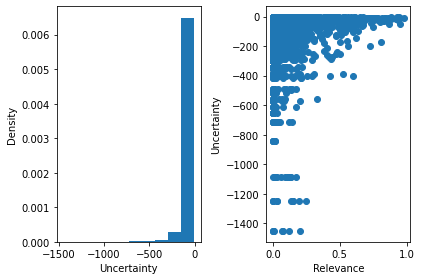

In [7]:
results = test_uncertain(UserSupport(base_MF=mlp, uncertainty=-data.user_support), data, name='MLP-NUS', max_k=10)
print(results['MAP-Uncertainty'])

## Item support

MLP-NIS - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.03262712 0.03842423 0.0491021  0.05139898 0.08884887 0.05890166
 0.06603044 0.01878531 0.03750673 0.04044256]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


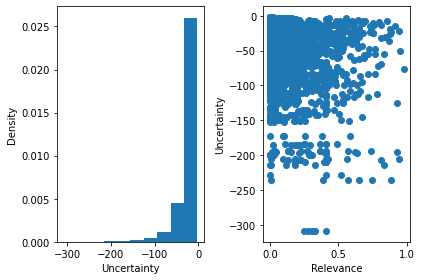

In [8]:
results = test_uncertain(ItemSupport(base_MF=mlp, uncertainty=-data.item_support), data, name='MLP-NIS', max_k=10)
print(results['MAP-Uncertainty'])

## MC Dropout

MCDropout - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.020658   0.03060444 0.03564142 0.03946697 0.04186857 0.04421491
 0.0458933  0.04776113 0.04862189 0.04986732]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


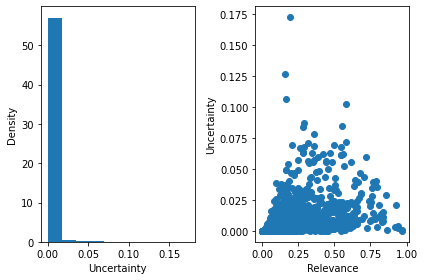

In [9]:
dropout = MCDropout(base_model=mlp, mc_iteration=5)
results = test_uncertain(dropout, data, max_k=10, name='MCDropout')
print(results['MAP'])

## Ensemble

MLP-ENSEMBLE - Recommending:   0%|          | 0/1307 [00:00<?, ?it/s]

[0.03442999 0.04667177 0.05738332 0.06424806 0.06895138 0.07152938
 0.07298794 0.07532031 0.07570029 0.0757485 ]


/home/vcoscrato/Documents/RecSys/MF/tests/Pointwise/DeskDrop/../notebook_utils.py:255: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  metrics['MAP-Uncertainty'][i] = MAP[indexer, -1].mean()


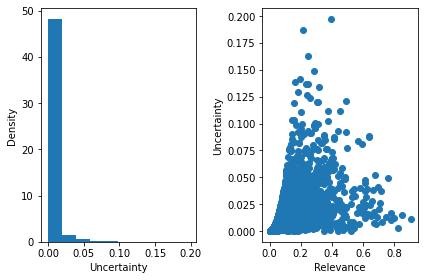

In [10]:
# Load params
best_params = study.best_params
data.batch_size = best_params['bs']
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 
               'n_negatives': best_params['neg'], 'dropout': best_params['layers']}

# Train
if trials > 0:
    for i in range(4):
        model = init_model(**best_params)
        train(model, data, path='checkpoints/ensemble_MLP', name=f'{i}')

# Load ensemble models
models = [mlp]
for file in os.listdir('checkpoints/ensemble_MLP'):
    models.append(init_model(**base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble_MLP', file))
    models[-1].eval()
ensemble = Ensemble(models)
clear_output(wait=True)
results = test_uncertain(ensemble, data, name='MLP-ENSEMBLE', max_k=10)
print(results['MAP'])

# BayesianMLP

[0.03672532 0.05202754 0.05974241 0.06616085 0.06839241 0.06945508
 0.07118507 0.07367168 0.07415792 0.07504392]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_pi,params_sigma1,params_sigma2,params_train_samples,user_attrs_filename,state
13,13,0.069277,2022-10-23 05:08:04.645771,2022-10-23 05:40:54.925680,0 days 00:32:50.279909,256,128,0.004258,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
14,14,0.063757,2022-10-23 05:40:54.926574,2022-10-23 06:11:44.536259,0 days 00:30:49.609685,256,128,0.002397,20,0.75,1.0,0.000335,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
12,12,0.060683,2022-10-23 04:52:14.757785,2022-10-23 05:08:04.644930,0 days 00:15:49.887145,256,128,0.005918,20,0.75,1.0,0.000912,3,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.058168,2022-10-22 13:29:58.348247,2022-10-22 13:50:19.728645,0 days 00:20:21.380398,256,128,0.004791,20,0.50,1.0,0.000912,2,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
11,11,0.056997,2022-10-23 04:39:11.565805,2022-10-23 04:52:14.756928,0 days 00:13:03.191123,256,128,0.005888,20,0.25,1.0,0.000912,4,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


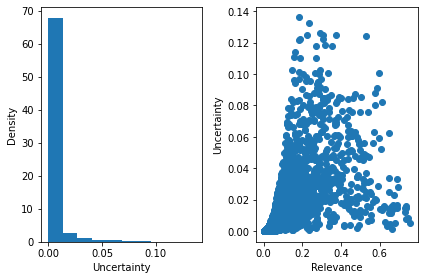

In [30]:
name = 'BayesianMLP'
def init_model(**kwargs):
    return BayesianMLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0, 'num_batches': int(len(data.train) / 256)}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 20, 20),
              'sample_train': trial.suggest_int('train_samples', 1, 10),
              'prior_pi': trial.suggest_categorical('pi', [1/4, 1/2, 3/4]),
              'prior_sigma_1': trial.suggest_categorical('sigma1', np.exp(-np.array([0, 1, 2]))),
              'prior_sigma_2': trial.suggest_categorical('sigma2', np.exp(-np.array([6, 7, 8])))}
    params['num_batches'] = int(len(data.train) / 256)
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=5)
BayesMLP, runs = load(init_model(**base_conf), study, top=0)
results = test_uncertain(BayesMLP, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

In [ ]:
name = 'BayesianMLP'
def init_model(**kwargs):
    return BayesianMLP(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'n_negatives': 0, 'num_batches': int(len(data.train) / 256)}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-4, 1e-2),
              'n_negatives': trial.suggest_int('neg', 20, 20),
              'sample_train': trial.suggest_int('train_samples', 1, 10),
              'prior_pi': trial.suggest_categorical('pi', [1/4, 1/2, 3/4]),
              'prior_sigma_1': trial.suggest_categorical('sigma1', np.exp(-np.array([0, 1, 2]))),
              'prior_sigma_2': trial.suggest_categorical('sigma2', np.exp(-np.array([6, 7, 8])))}
    params['num_batches'] = int(len(data.train) / 256)
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=5)
BayesMLP, runs = load(init_model(**base_conf), study, top=0)
results = test_uncertain(BayesMLP, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
runs[:5]

[0.00533944 0.00610221 0.00839054 0.00953471 0.01060259 0.0114925
 0.01176492 0.0119874  0.01232641 0.01266966]


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_var,params_wd,user_attrs_filename,state
9,9,0.036808,2022-12-13 16:42:01.270066,2022-12-13 16:42:14.644971,0 days 00:00:13.374905,256,128,0.001503,20,NaN,0.000064,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
20,20,0.032975,2022-12-14 17:50:18.358553,2022-12-14 17:53:00.903745,0 days 00:02:42.545192,256,128,0.000086,14,6.415948,0.000040,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
7,7,0.031816,2022-12-13 16:41:34.228473,2022-12-13 16:41:47.801994,0 days 00:00:13.573521,256,128,0.004985,17,NaN,0.000044,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
3,3,0.030664,2022-12-13 16:40:32.488621,2022-12-13 16:40:56.261518,0 days 00:00:23.772897,256,128,0.002969,4,NaN,0.000043,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE
15,15,0.030649,2022-12-13 16:43:26.705058,2022-12-13 16:43:58.674794,0 days 00:00:31.969736,256,128,0.000475,16,NaN,0.000079,/home/vcoscrato/Documents/RecSys/MF/tests/Poin...,COMPLETE


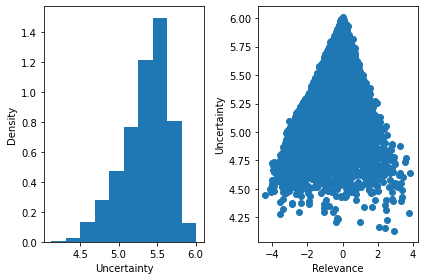

In [30]:
name = 'CPMF-Pointwise'
def init_model(**kwargs):
    return CPMF(data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim': 10, 'lr': 0, 'weight_decay': 0, 'loss':'GBR', 'n_negatives': 0}

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 256, 256)
    params = {'embedding_dim': trial.suggest_int('dim', 128, 128),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 1e-4),
              'n_negatives': trial.suggest_int('neg', 1, 20),
              'init_var': trial.suggest_float('var', 1, 25)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
mf = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[1])
results = test_uncertain(mf, data, max_k=10, name=name)

clear_output(wait=True)
print(results['MAP'])
best_runs

# Results

In [3]:
# Load results
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
    order = ['MF-BPR', 'MF-BCE', 'MF-MSE', 'CPMF-Pairwise', 'CPMF-Pointwise']
# order = ['MF', 'MF-NUS', 'MF-NIS', 'MF-ENSEMBLE', 'MLP', 'MLP-NUS', 'MLP-NIS', 'MLP-ENSEMBLE', 'MCDropout', 'BayesianMLP', 'GER', 'CPMF']
results = pd.DataFrame([results[key] for key in order], index=order)

# Plot aestetics
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r', 'm']
colors = {k:c for k, c in zip(results.index, colors)}
lines = ['o', 'v', '^', '<', '>', 's', 'p', '+', 'x', '*', 'p']
lines = {k: '-' + l for k, l, in zip(results.index, lines)}

# Results
results[['FCP', 'URI', 'UAC']]

,FCP,URI,UAC
MF-BPR,0.741598,0.236249,-0.083761
MF-BCE,0.740091,0.254011,-0.107621
MF-MSE,0.633498,NaN,NaN
CPMF-Pairwise,0.724639,-0.022930,-0.024637
CPMF-Pointwise,0.738121,0.002250,-0.051186


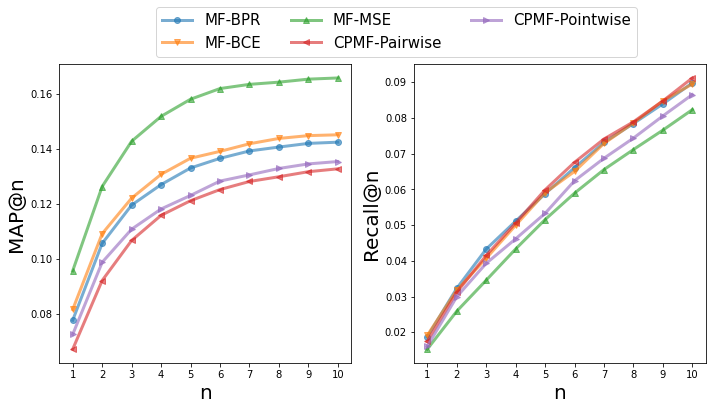

In [4]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.iterrows():
    ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.9, 1.15))
f.tight_layout()
f.savefig('plots/accuracy.pdf')

,MAP,MAP2,Recall,Recall2
CPMF-Pairwise,0.132740,0.129108,0.091220,0.091527
CPMF-Pointwise,0.135385,0.132401,0.086564,0.090156


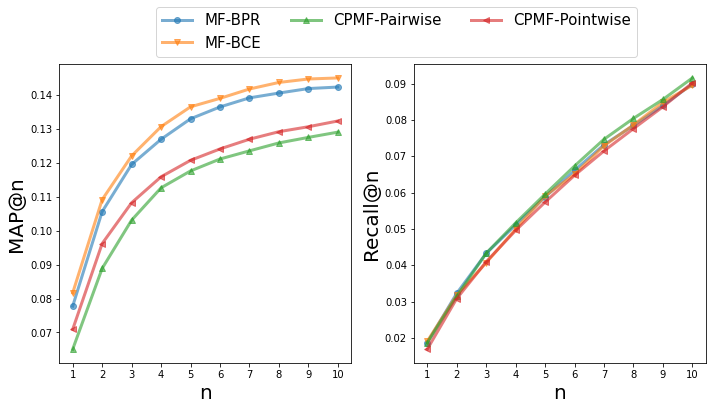

In [28]:
## Top-K accuracy metrics
f, ax = plt.subplots(figsize=(10, 5), ncols=2)
for index, row in results.iterrows():
    try:
        ax[0].plot(np.arange(1, 11), row['MAP2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[1].plot(np.arange(1, 11), row['Recall2'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    except:
        ax[0].plot(np.arange(1, 11), row['MAP'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
        ax[1].plot(np.arange(1, 11), row['Recall'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[1].set_xticks(np.arange(1, 11))
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.9, 1.15))
f.tight_layout()
f.savefig('plots/accuracy.pdf')
results.drop(index=['MF-BPR', 'MF-BCE'])[['MAP', 'MAP2', 'Recall', 'Recall2']].transform(lambda x: x.str[-1])

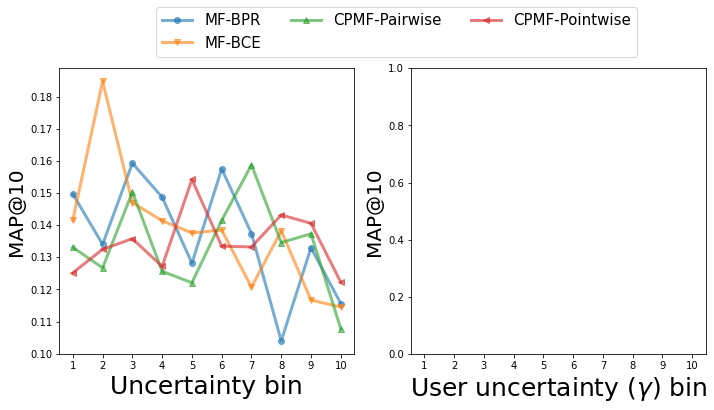

In [31]:
## MAP vs Uncertainty and vs UserUnceratinty
f, ax = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
x = np.arange(10) + 1
for index, row in results.iterrows():
    ax[0].plot(x, row['MAP-Uncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    try:
        ax[1].plot(x, row['MAP-UserUncertainty'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    except:
        pass
ax[0].set(xticks = x)
ax[0].set_xlabel('Uncertainty bin', fontsize=25)
ax[0].set_ylabel('MAP@10', fontsize=20)
ax[1].set_xlabel(r'User uncertainty $(\gamma)$ bin', fontsize=25)
ax[1].set_ylabel('MAP@10', fontsize=20)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.9, 1.15))
f.tight_layout()
f.savefig('plots/MAP-Uncertainty.pdf')

KeyError: 'MAP-ProfSize'

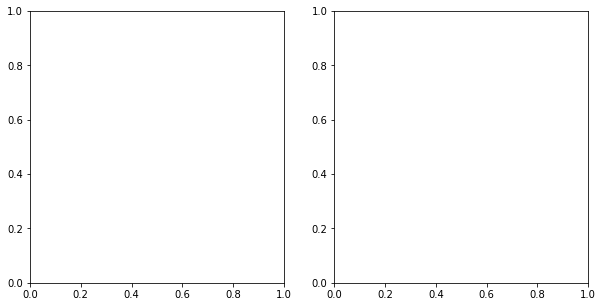

In [32]:
## MAP and Uncertainty vs Profile size
f, ax = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
for index, row in results.iterrows():
    ax[0].plot(x, row['MAP-ProfSize'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
    ax[1].plot(x, row['Uncertainty-ProfSize'], lines[index], color=colors[index], label=index, linewidth=3, alpha=0.6)
ax[0].set(xticks = x)
ax[0].set_xlabel('Profile size bin', fontsize=25)
ax[0].set_ylabel('MAP@10', fontsize=20)
ax[1].set_ylabel('Average uncertainty', fontsize=20)
ax[1].set_xlabel('Profile size bin', fontsize=25)
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, fontsize=15, ncol=3, bbox_to_anchor=(0.9, 1.15))
f.tight_layout()
f.savefig('plots/MAP-ProfSize.pdf')
np.corrcoef(mf.get_user_uncertainty(), data.user_support)

CPMF-Pairwise     8
CPMF-Pointwise    9
Name: unc_MAP, dtype: int64


array([-0.73333333, -0.2       ])

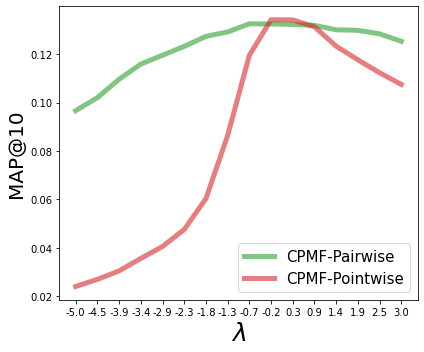

In [37]:
## MAP vs Coverage
f, ax = plt.subplots(figsize=(6, 5))
x = np.linspace(-5, 3, 16)
for index, row in results.drop(['MF-BPR', 'MF-BCE']).iterrows():
    ax.plot(x, row['unc_MAP'], '-', color=colors[index], label=index, linewidth=5, alpha=0.6)
ax.set(xticks = x, xticklabels = [str(round(x, 1)) for x in x])
ax.set_xlabel(r'$\lambda$', fontsize=25)
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend(fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy_lambda.pdf')
idx = results.drop(index=['MF-BPR', 'MF-BCE'])['unc_MAP'].transform(np.argmax); print(idx)
x[idx]

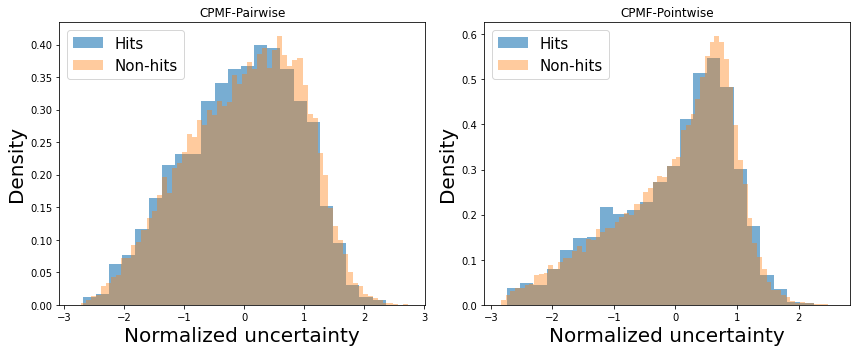

In [38]:
idx = ['CPMF-Pairwise', 'CPMF-Pointwise']
f, ax = plt.subplots(figsize=(12, 5), ncols=len(idx))
for i, model in enumerate(idx):
    ax[i].hist(results.loc[model]['norm_unc'][0], bins='auto', alpha=0.6, density=True, label='Hits')
    ax[i].hist(results.loc[model]['norm_unc'][1], bins='auto', alpha=0.4, density=True, label='Non-hits')
    ax[i].legend(fontsize=15)
    ax[i].set_xlabel('Normalized uncertainty', fontsize=20)
    ax[i].set_ylabel('Density', fontsize=20)
    ax[i].set_title(model)
f.tight_layout()
f.savefig('plots/normalized_uncertainty.pdf')